In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from keras.models import Sequential
from keras.layers import *

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


# Summary
...

---

### Load the data in
The test data is not used

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))

---

### Some custom definitions
* metrics
* loss functions
* choice of learning parameters and settings

In [29]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
        positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):
    
    def recall(y_true, y_pred):

        true_positives = K.sum(y_true * y_pred, axis=0)
        actual_ones = K.sum(y_true, axis=0)
        recall = true_positives / (actual_ones + K.epsilon())
        return recall

    
    def precision(y_true, y_pred):
        
        true_positives = K.sum(y_true * y_pred, axis=0)
        positives = K.sum(y_pred, axis=0)
        precision = true_positives / (positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    macroF1 = K.mean( 2*((precision*recall)/(precision+recall+K.epsilon())) ) 
    
    return 1-macroF1

# weighted categorical crossentropy
def my_crossE(y_true, y_pred):
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = class_weights * class_entropy
    return 1-K.mean(weighted_entropy)/1000  # arbitrary numbers to make it close to [0-1] interval

In [30]:
# some other global learning settings

batch_size = 3000
#patience = 4
optimizer = 'adam' # 'rmsprop'
my_metrics = [macroPrec, macroF1, macroRecall, my_crossE]

In [31]:
# auxiliary functions
    

# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(18, 5))
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history.history[metric]
        val_results = history.history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history.history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()
    

# choose callback functions to be given in model.fit(...)
def callbacks(LRfactor=0.5):
    return [ReduceLROnPlateau(factor=LRfactor, patience = patience//2),
            EarlyStopping(monitor='val_macroF1', mode='max', patience=patience)
           ]

---

### Define a wrapper class for creating the classification model with embedding, fitting, etc.
It creates an useful object using a list of intermediate layers as the main argument.
Makes it easier to consistently use the chosen metrics, loss function, class_weights, embedding etc.

In [32]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=None, class_weight=class_weights, epochs=15,\
                 embedd = None, embedd_dims=[None]*3):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.class_weight = class_weight
        self.epochs = epochs
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            self.embedd_weights = pickle.load(open(embedd, "rb"))
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=False))
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history)
        
    def save_embedd(self, name):
        pickle.dump(self.model.layers[0].get_weights(), open(f"embedd_weights_{name}.p", "wb"))
        
    def Ksave(self, name):
        self.model.save(f"Kmodel_with_embedd_{name}.h5")
    
    def save(self, name):
        pickle.dump(self, open(f"blackbox_with_embedd_{name}.p", "wb"))
 


---

## Training a keras-layer embedding
### (naively, not CBOW or skipgram)
* using only global-average-pooling before softmax
* training for a fixed, short number of epochs: the goal is not to train the dense classification layer but to pretrain the embedding
* mask zeros in input
* use class_weights with default keras loss functions
* do not use class_weights with fuzzy_macroF1 or my_crossE
* save weights to files
* see which loss function got the best val_macroF1 at the last epoch

In [33]:
# dimension of the embedding space, output_dim

layers1 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model1 = BlackBox(layers=layers1, loss='categorical_crossentropy', class_weight=class_weights, metrics=my_metrics)
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
global_average_pooling1d_6 ( (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 13,865,506
Trainable params: 13,865,506
Non-trainable params: 0
_________________________________________________________________


In [34]:
model1.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/15
500000/500000 [==============================] - 255s 510us/step - loss: 1.2563 - macroPrec: 0.0765 - macroF1: 0.0632 - macroRecall: 0.0649 - my_crossE: 1.9531 - val_loss: 0.8445 - val_macroPrec: 0.3059 - val_macroF1: 0.1539 - val_macroRecall: 0.1656 - val_my_crossE: 2.0432
Epoch 2/15
500000/500000 [==============================] - 265s 529us/step - loss: 0.6439 - macroPrec: 0.4041 - macroF1: 0.2746 - macroRecall: 0.2520 - my_crossE: 1.9997 - val_loss: 0.4840 - val_macroPrec: 0.4661 - val_macroF1: 0.3941 - val_macroRecall: 0.3555 - val_my_crossE: 1.9498
Epoch 3/15
500000/500000 [==============================] - 270s 539us/step - loss: 0.4085 - macroPrec: 0.4570 - macroF1: 0.4241 - macroRecall: 0.4001 - my_crossE: 1.9041 - val_loss: 0.3573 - val_macroPrec: 0.4521 - val_macroF1: 0.4367 - val_macroRecall: 0.4229 - val_my_crossE: 1.8665
Epoch 4/15
500000/500000 [==============================] - 270s 539us/step - loss: 0.3273

KeyError: 'lr'

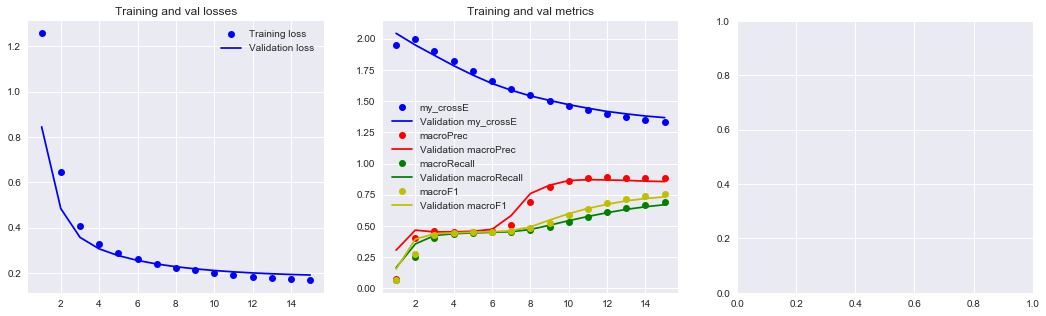

In [35]:
model1.plot()

In [ ]:
model1.save_embedd("50dim_GlblAvg_CatCrossE")
#model1.Ksave("50dim_GlblAvg_CatCrossE")
#model1.save("50dim_GlblAvg_CatCrossE")

---

In [ ]:
# dimension of the embedding space, output_dim
# custom loss

layers2 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model2 = BlackBox(layers=layers1, loss=fuzzy_macroF1_flip, class_weight=None, metrics=my_metrics)
model2.summary()

In [ ]:
model2.fit()

In [ ]:
model2.plot()

In [ ]:
model2.save_embedd("50dim_GlblAvg_F1flip")
# model2.Ksave("50dim_GlblAvg_F1flip")
# model2.save("50dim_GlblAvg_F1flip")

---

In [ ]:
# dimension of the embedding space, output_dim
# custom loss_2

layers3 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           GlobalAveragePooling1D()]

model3 = BlackBox(layers=layers1, loss=my_crossE, class_weight=None, metrics=my_metrics)
model3.summary()

In [ ]:
model3.fit()

In [ ]:
model3.plot()

In [ ]:
model3.save_embedd("50dim_GlblAvg_MyCrossE")
# model3.Ksave("50dim_GlblAvg_MyCrossE")
# model3.save("50dim_GlblAvg_MyCrossE")

---